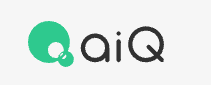

[disclaimer](./disclaimer.txt/)

# aiQ POS Retailer Data Evaluation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import plotly.io

for_html = False
if for_html:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

sys.path.append('../..')
from aiq_strategy_robot.data.data_accessor import DAL
from utils.shortcut import aiq_pos_retailer as sc

## データロード & AltDataEvaluatorの作成

In [3]:
sdh = DAL()
sample_target = "1925 JP"
sc.load_sample_dataset(sdh)

display(sdh.extract_definition)

data_id_alt = 1
data_id_mkt = 2
data_id_funda = 3

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,aiq_pos_elec,Unknown,Unknown,Unknown,"[1925 JP, 2212 JP, 2267 JP, 2651 JP, 2653 JP, ...","[ticker, datetime]",2010-04-30 00:00:00,2024-02-29 00:00:00
2,RawData,mkt,Unknown,Unknown,Unknown2,"[1925 JP, 2212 JP, 2267 JP, 2651 JP, 2653 JP, ...","[ticker, datetime]",2007-01-04 00:00:00,2024-06-14 00:00:00
3,RawData,finnhub,fundamental,Unknown,Unknown3,"[1925 JP, 2212 JP, 2267 JP, 2651 JP, 2653 JP, ...","[ticker, datetime]",2014-06-30 00:00:00,2024-02-29 00:00:00


In [4]:
display(sdh.get_raw_data(data_id_alt).tail())
display(sdh.get_raw_data(data_id_mkt).tail())
display(sdh.get_raw_data(data_id_funda).tail())

variable            pos_sales     share
ticker  datetime                       
9994 JP 2023-10-31   2.865630  0.374847
        2023-11-30   2.835208  0.381671
        2023-12-31   3.703306  0.362323
        2024-01-31   2.650472  0.371226
        2024-02-29   2.776912  0.368321

close
ticker  datetime          
9994 JP 2024-06-10  3105.0
        2024-06-11  3100.0
        2024-06-12  3090.0
        2024-06-13  3075.0
        2024-06-14  3075.0

announcement_date  year  quarter  costOfGoodsSold  \
ticker  datetime                                                       
9994 JP 2022-12-31        2023-02-10  2023        3          29715.0   
        2023-03-31        2023-05-12  2023        4          25118.0   
        2023-06-30        2023-08-10  2024        1          27814.0   
        2023-09-30        2023-11-10  2024        2          29949.0   
        2023-12-31        2024-02-09  2024        3          30663.0   

                    dilutedAverageSharesOutstanding  dilutedEPS    ebit  \
ticker  datetime                                                          
9994 JP 2022-12-31                           10.841   112.07453  1914.0   
        2023-03-31                           10.841    13.92860   389.0   
        2023-06-30                           10.841    73.51720  1322.0   
        2023-09-30                           10.841    63.73951  1248.0   
        2023-12-31                           10.841   142.79126  2667.0   

                    gainLossOnDispositionOfAssets  grossIncome  \
ticker  datetime                                                 
9994 JP 2022-12-31                            2.0      11824.0   
        2023-03-31                            0.0      10338.0   
        2023-06-30                            0.0      11096.0   
        2023-09-30                            0.0      11290.0   
        2023-12-31                            1.0      12980.0   

                    interestIncomeExpense  ...  netIncomeAfterTaxes  \
ticker  datetime                           ...                        
9994 JP 2022-12-31                    6.0  ...               1195.0   
        2023-03-31                  -25.0  ...                 69.0   
        2023-06-30                   -7.0  ...                915.0   
        2023-09-30                  -20.0  ...                762.0   
        2023-12-31                   21.0  ...               1750.0   

                    nonRecurringItems  pretaxIncome  provisionforIncomeTaxes  \
ticker  datetime                                                               
9994 JP 2022-12-31             -126.0        1810.0                    615.0   
        2023-03-31             -314.0          87.0                     18.0   
        2023-06-30             -105.0        1257.0                    342.0   
        2023-09-30             -359.0         893.0                    131.0   
        2023-12-31             -336.0        2382.0                    632.0   

                    revenue  sgaExpense  totalOperatingExpense  \
ticker  datetime                                                 
9994 JP 2022-12-31  41539.0      9910.0                 9910.0   
        2023-03-31  35456.0      9949.0                 9949.0   
        2023-06-30  38910.0      9773.0                 9774.0   
        2023-09-30  41239.0     10043.0                10042.0   
        2023-12-31  43643.0     10312.0                10313.0   

                    totalOtherIncomeExpenseNet  otherOperatingExpensesTotal  \
ticker  datetime                                                              
9994 JP 2022-12-31                        14.0                          NaN   
        2023-03-31                        37.0                          0.0   
        2023-06-30                        47.0                          1.0   
        2023-09-30                        24.0                         -1.0   
        2023-12-31                        29.0                          1.0   

                    depreciationAmortization  
ticker  datetime                              
9994 JP 2022-12-31                       NaN  
        2023-03-31                       NaN  
        2023-06-30                       NaN  
        2023-09-30                       NaN  
        2023-12-31                       NaN  

[5 rows x 22 columns]

### AltDataEvaluatorを作成

In [5]:
from aiq_strategy_robot.evaluator import AltDataEvaluator

# Initialize AltDataEvaluator
ade = AltDataEvaluator(sdh)

## 相関計算

### 四半期売上高との相関を計算

> 売上高の時系列幅に合わせてリサンプルします.

In [6]:
sdh.transform.clear()
funda_kpi_id = sdh.transform.resample(data_id=data_id_funda, fields='revenue', rule='Q', func='last').variable_ids[0]
pos_Q_ids = sdh.transform.resample(data_id=data_id_alt, rule='Q', func='last').variable_ids

#### 四半期売上高とのプロット

ハンドラの`show_line_one_target`で、特定TickerのKPI(y)とTruValuデータとのプロットを行います.

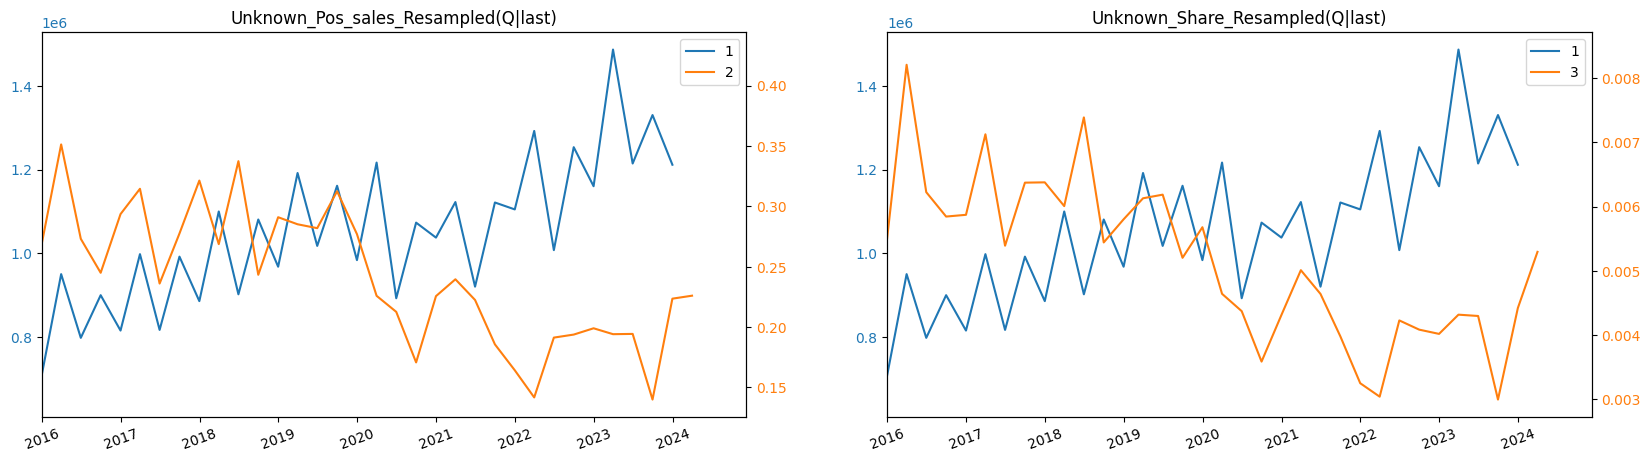

In [7]:
sdh.show_line_one_target(
    target=sample_target,
    y=funda_kpi_id,
    X= pos_Q_ids[:],
    col_num=2,
    vname_len_limit=40,
    start_date='2016-01-01'
)

> データの時系列をshiftすることで売上高とのプロットがどのように変化するかを見ます.

In [8]:

shft1_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample(rule='Q', func='mean').variable_ids
shft2_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample(rule='Q', func='mean').variable_ids
shft3_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample(rule='Q', func='mean').variable_ids
shft4_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample(rule='Q', func='mean').variable_ids
shft5_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=5).resample(rule='Q', func='mean').variable_ids
shft6_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=6).resample(rule='Q', func='mean').variable_ids
shft7_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=7).resample(rule='Q', func='mean').variable_ids
shft8_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=8).resample(rule='Q', func='mean').variable_ids
shft9_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=9).resample(rule='Q', func='mean').variable_ids
shft10_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=10).resample(rule='Q', func='mean').variable_ids
shft11_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=11).resample(rule='Q', func='mean').variable_ids
shft12_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=12).resample(rule='Q', func='mean').variable_ids
shft13_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=13).resample(rule='Q', func='mean').variable_ids
shft14_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=14).resample(rule='Q', func='mean').variable_ids
shft15_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=15).resample(rule='Q', func='mean').variable_ids
shft16_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=16).resample(rule='Q', func='mean').variable_ids

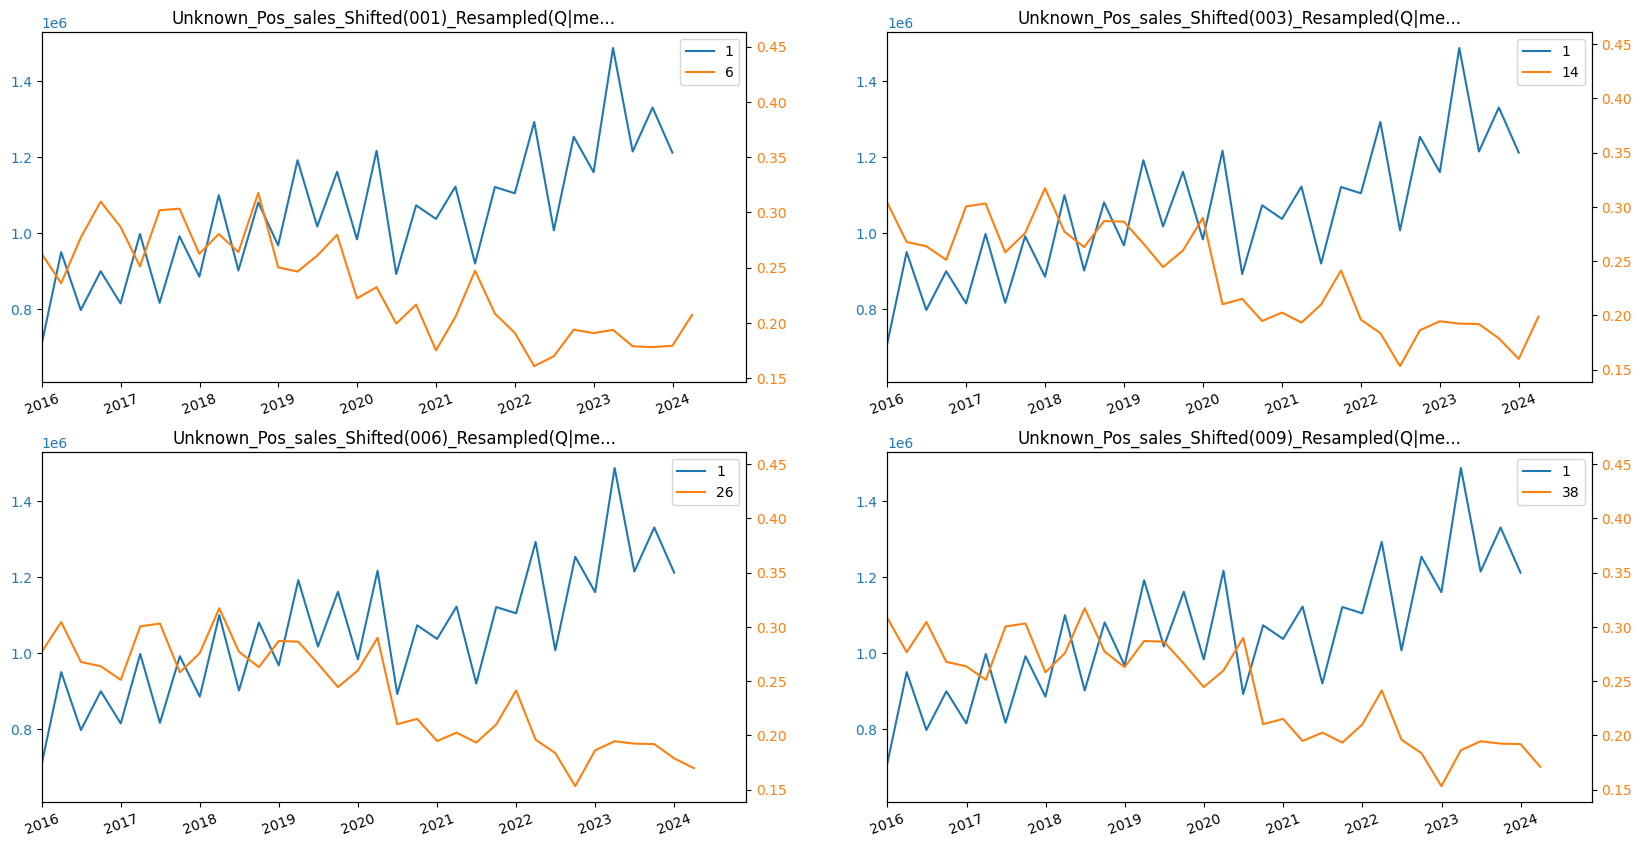

In [9]:
sdh.show_line_one_target(
    target=sample_target,
    y=funda_kpi_id,
    X= [shft1_Q_ids[0], shft3_Q_ids[0], shft6_Q_ids[0], shft9_Q_ids[0]],
    col_num=2,
    vname_len_limit=45,
    start_date='2016-01-01'
)

> 特徴量を対数変換して相関計算を行います


In [10]:
funda_kpi_log_id = sdh.transform.log_diff(fields=funda_kpi_id, periods=4).diff(periods=1).variable_ids[-1]

shft0_Q_log_ids = sdh.transform.log_diff(fields=pos_Q_ids, periods=4).diff(periods=1).variable_ids
shft1_Q_log_ids = sdh.transform.log_diff(fields=shft1_Q_ids, periods=4).diff(periods=1).variable_ids
shft2_Q_log_ids = sdh.transform.log_diff(fields=shft2_Q_ids, periods=4).diff(periods=1).variable_ids
shft3_Q_log_ids = sdh.transform.log_diff(fields=shft3_Q_ids, periods=4).diff(periods=1).variable_ids
shft4_Q_log_ids = sdh.transform.log_diff(fields=shft4_Q_ids, periods=4).diff(periods=1).variable_ids
shft5_Q_log_ids = sdh.transform.log_diff(fields=shft5_Q_ids, periods=4).diff(periods=1).variable_ids
shft6_Q_log_ids = sdh.transform.log_diff(fields=shft6_Q_ids, periods=4).diff(periods=1).variable_ids
shft7_Q_log_ids = sdh.transform.log_diff(fields=shft7_Q_ids, periods=4).diff(periods=1).variable_ids
shft8_Q_log_ids = sdh.transform.log_diff(fields=shft8_Q_ids, periods=4).diff(periods=1).variable_ids
shft9_Q_log_ids = sdh.transform.log_diff(fields=shft9_Q_ids, periods=4).diff(periods=1).variable_ids
shft10_Q_log_ids = sdh.transform.log_diff(fields=shft10_Q_ids, periods=4).diff(periods=1).variable_ids
shft11_Q_log_ids = sdh.transform.log_diff(fields=shft11_Q_ids, periods=4).diff(periods=1).variable_ids
shft12_Q_log_ids = sdh.transform.log_diff(fields=shft12_Q_ids, periods=4).diff(periods=1).variable_ids
shft13_Q_log_ids = sdh.transform.log_diff(fields=shft13_Q_ids, periods=4).diff(periods=1).variable_ids
shft14_Q_log_ids = sdh.transform.log_diff(fields=shft14_Q_ids, periods=4).diff(periods=1).variable_ids
shft15_Q_log_ids = sdh.transform.log_diff(fields=shft15_Q_ids, periods=4).diff(periods=1).variable_ids
shft16_Q_log_ids = sdh.transform.log_diff(fields=shft16_Q_ids, periods=4).diff(periods=1).variable_ids

#### 相関計算

In [11]:
ori_cols = sdh.get_raw_data(data_id_alt).columns
ori_cols

Index(['pos_sales', 'share'], dtype='object', name='variable')

In [12]:
rho_pool = pd.DataFrame()
rho_pool['shift=0'] = ade.compu_rho(shft0_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=1'] = ade.compu_rho(shft1_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=2'] = ade.compu_rho(shft2_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=3'] = ade.compu_rho(shft3_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=4'] = ade.compu_rho(shft4_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=5'] = ade.compu_rho(shft5_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=6'] = ade.compu_rho(shft6_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=7'] = ade.compu_rho(shft7_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=8'] = ade.compu_rho(shft8_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=9'] = ade.compu_rho(shft9_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=10'] = ade.compu_rho(shft10_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=11'] = ade.compu_rho(shft11_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=12'] = ade.compu_rho(shft12_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=13'] = ade.compu_rho(shft13_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=14'] = ade.compu_rho(shft14_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=15'] = ade.compu_rho(shft15_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=16'] = ade.compu_rho(shft16_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)

display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

,shift=0,shift=1,shift=2,shift=3,shift=4,shift=5,shift=6,shift=7,shift=8,shift=9,shift=10,shift=11,shift=12,shift=13,shift=14,shift=15,shift=16
pos_sales,1.520098,5.067387,2.188132,1.597334,0.547873,1.079427,-1.084959,1.060402,0.617874,0.670307,0.466016,-1.045377,0.407596,-1.295833,-1.001422,-2.452885,-2.012709
share,0.968154,3.406052,1.623229,1.278352,1.214313,1.966917,-0.483761,0.920069,0.143428,0.888630,0.959884,-0.051293,0.557119,-0.811253,-0.800627,-2.582769,-1.942060


> もっとも相関の良い変数のうち、さらに上記N件のTickerを確認します.

In [13]:
rho_time = ade.compu_rho(shft1_Q_log_ids, funda_kpi_log_id, by='ticker', rename_features=ori_cols)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

,pos_sales,share
ticker,,
3094 JP,7.048229,2.012253
3349 JP,6.679520,5.387368
3080 JP,3.672793,1.218693
3086 JP,3.451485,2.659069
2782 JP,2.921875,2.761120


> 変数を確認して散布図でplot

In [14]:
display(sdh.transform.find_variables(shft1_Q_log_ids))

feature = 76 # pos_sales

,variable_id,data_id,data_source,source,table,field,ticker,reference_id,variable_type,method,params,process_id
variable_name,,,,,,,,,,,,
Unknown_Pos_sales_Shifted(001)_Resampled(Q|mean)_LogDiff(004)_Diff(001),76,1,aiq_pos_elec,Unknown,Unknown,Unknown_Pos_sales_Shifted(001)_Resampled(Q|mea...,None,74,feature,diff,periods=1,40
Unknown_Share_Shifted(001)_Resampled(Q|mean)_LogDiff(004)_Diff(001),77,1,aiq_pos_elec,Unknown,Unknown,Unknown_Share_Shifted(001)_Resampled(Q|mean)_L...,None,75,feature,diff,periods=1,40


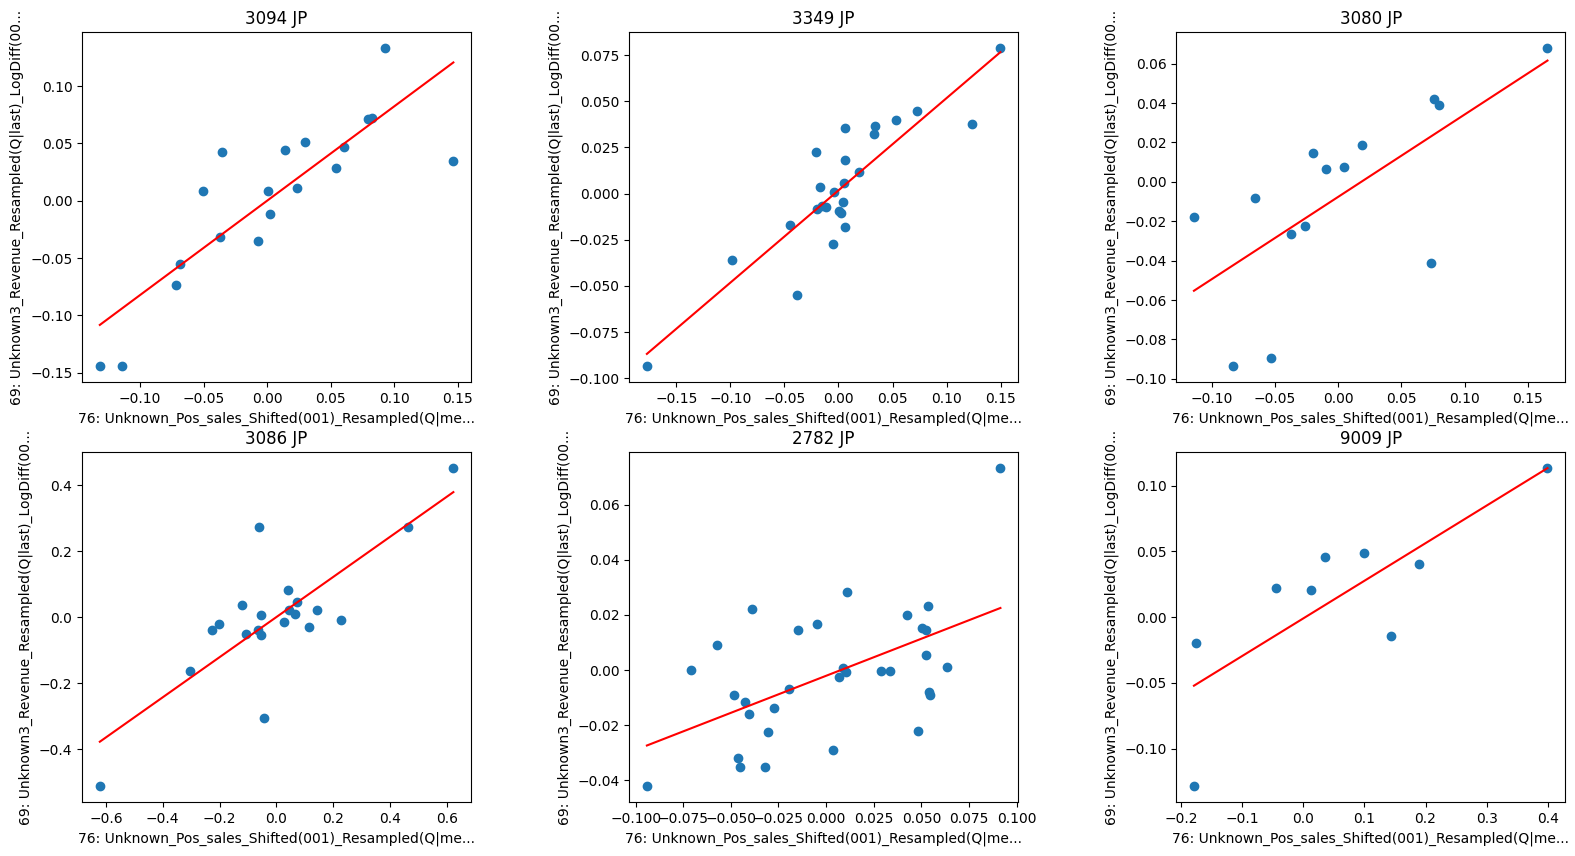

In [15]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=funda_kpi_log_id,
    x=feature,
    targets=top6tickers,
    col_num=3,
    vname_len_limit=45,
    start_date='2016-01-01'
)

### 株価変化率との相関

> 月次データにリサンプル

In [16]:
resample_term = 'M'
n_rolling = 2  # 2 months rolling mean

alt_M_ids = sdh.transform.resample(data_id=data_id_alt, rule=resample_term, func='last').sma(n_rolling).variable_ids
mkt_M_close_id = sdh.transform.resample('D', 'last', data_id=data_id_mkt, fields='close').fillna('ffill').shift(-7).reindex(label=alt_M_ids[0]).variable_ids[-1]

> pos_sales * shareを特徴量として追加

In [17]:
pos_sales, share = alt_M_ids
pos_sales_vs_share = sdh.transform.multiply(x1field=pos_sales, x2field=share, name='pos_sales * share').variable_ids[0]

In [18]:
alt_M_ids = [pos_sales, share, pos_sales_vs_share]
alt_names = ["pos_sales", "share", "pos_sales * share"]

> 価格データとposデータをVisualtize

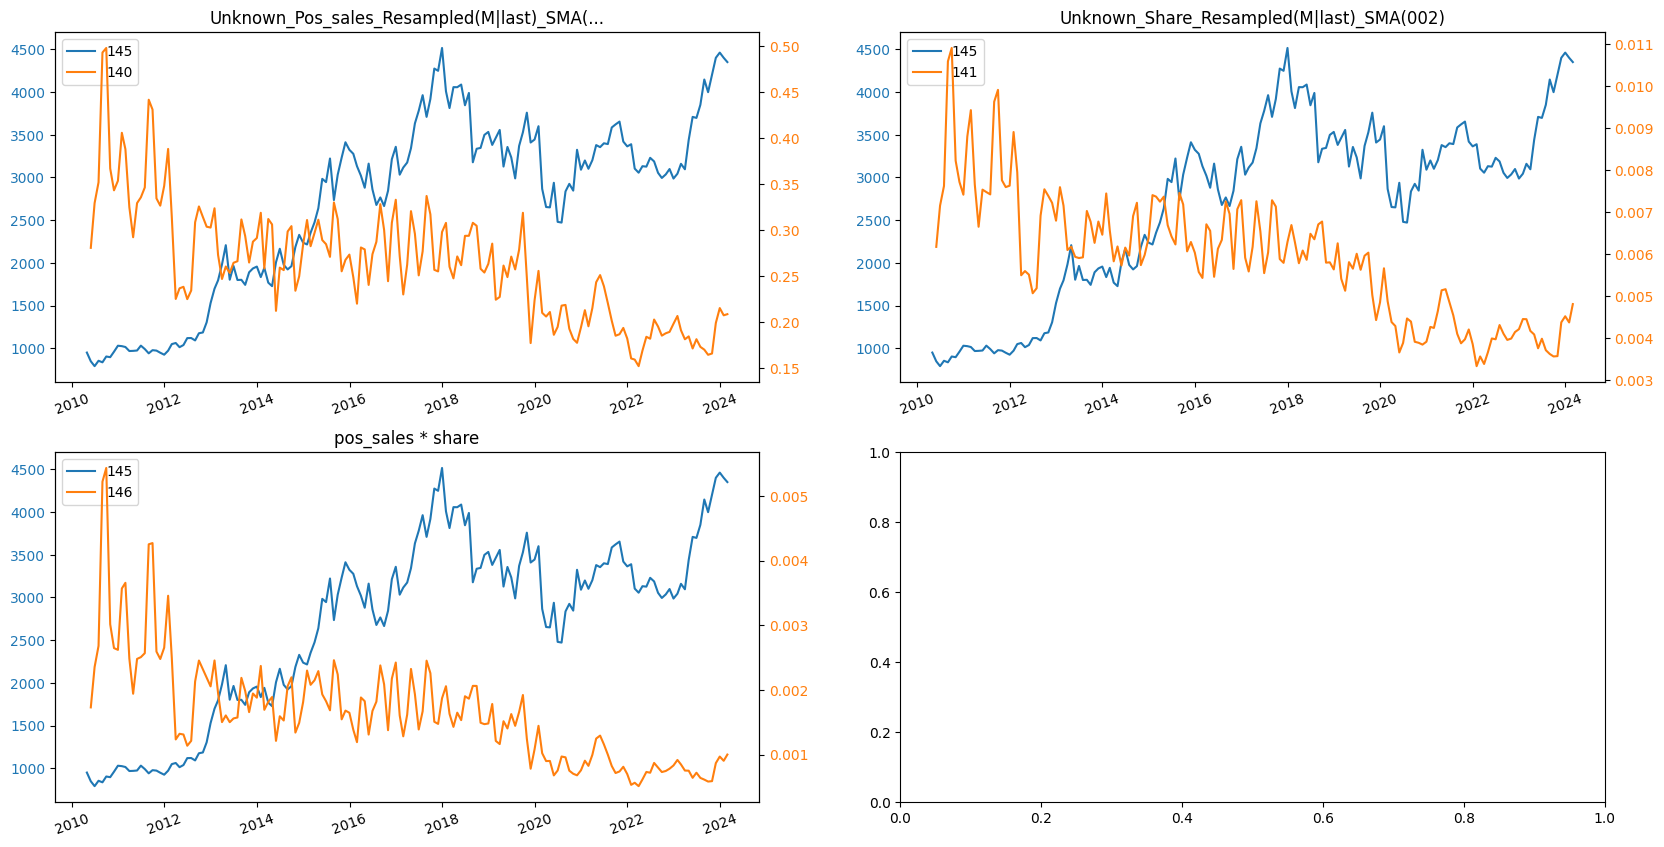

In [19]:
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_M_close_id,
    X= alt_M_ids[:4],
    col_num=2,
    vname_len_limit=40,
)

> データの時系列をshiftすることで売上高とのプロットがどのように変化するかを見ます.

In [20]:
shift1_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=1).variable_ids
shift2_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=2).variable_ids
shift3_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=3).variable_ids
shift4_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=4).variable_ids
shift5_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=5).variable_ids
shift6_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=6).variable_ids
shift7_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=7).variable_ids
shift8_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=8).variable_ids

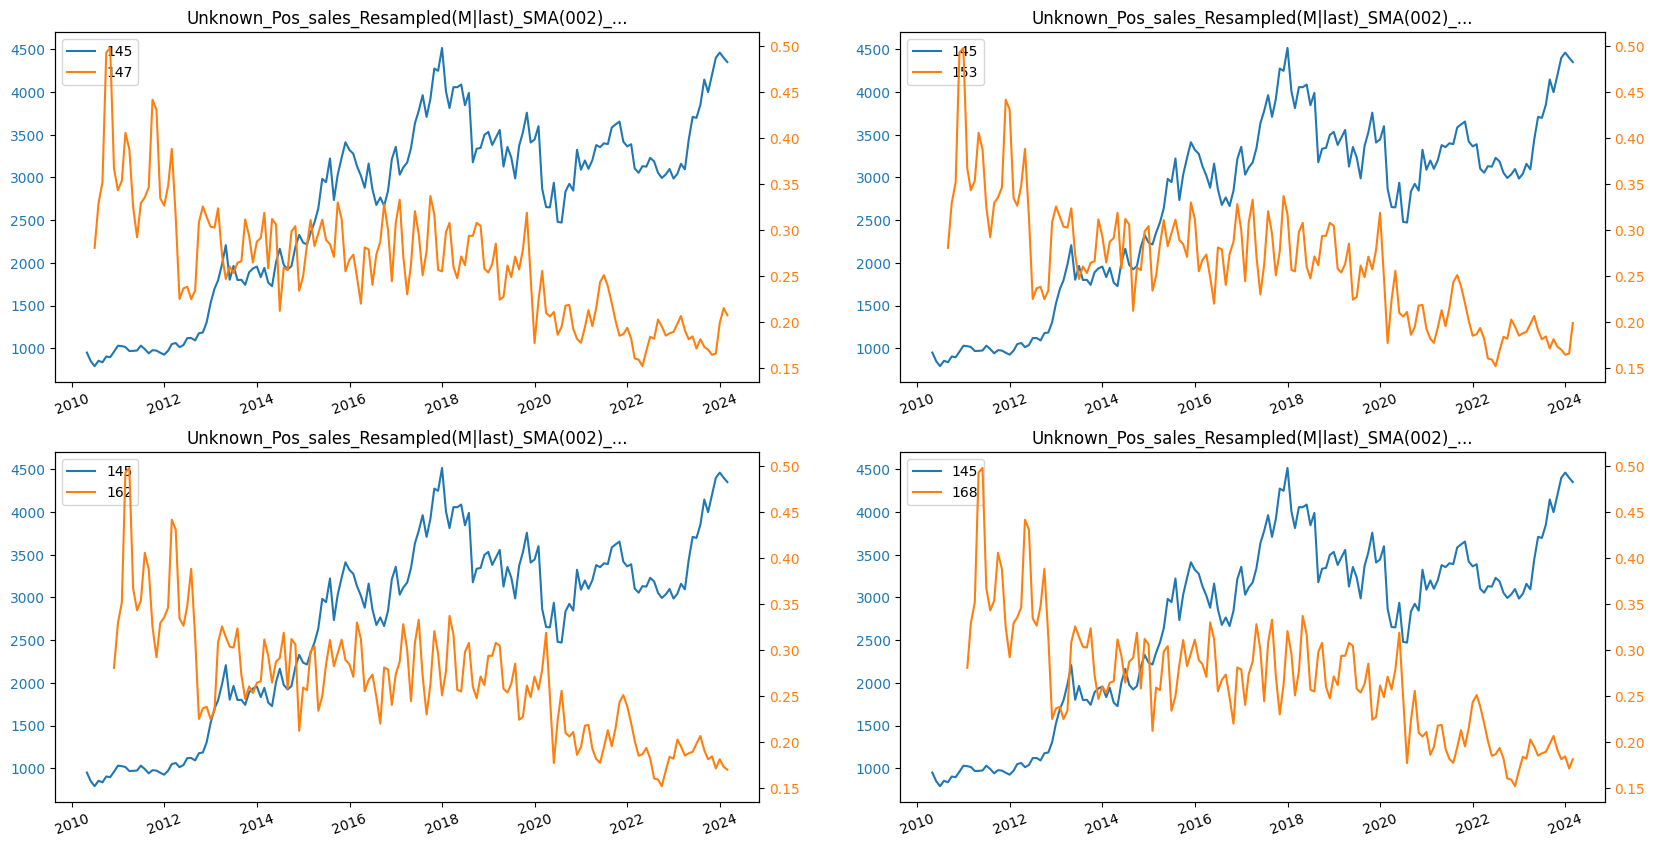

In [21]:
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_M_close_id,
    X= [shift1_M_ids[0], shift3_M_ids[0], shift6_M_ids[0], shift8_M_ids[0]],
    col_num=2,
    vname_len_limit=45,
)

##### 特徴量を対数変換して相関計算を行う.

In [22]:
close_return = sdh.transform.dropna(fields=mkt_M_close_id).log_diff(1).variable_ids[-1]

In [23]:

n_diff = 12  # 12 months (1 year) difference
log_shift0_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).variable_ids
log_shift1_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=1).variable_ids
log_shift2_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=2).variable_ids
log_shift3_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=3).variable_ids
log_shift4_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=4).variable_ids
log_shift5_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=5).variable_ids
log_shift6_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=6).variable_ids
log_shift7_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=7).variable_ids
log_shift8_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=8).variable_ids

In [24]:
rho_pool = pd.DataFrame()
rho_pool['shift=0'] = ade.compu_rho(log_shift0_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=1'] = ade.compu_rho(log_shift1_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=2'] = ade.compu_rho(log_shift2_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=3'] = ade.compu_rho(log_shift3_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=4'] = ade.compu_rho(log_shift4_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=5'] = ade.compu_rho(log_shift5_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=6'] = ade.compu_rho(log_shift6_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=7'] = ade.compu_rho(log_shift7_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=8'] = ade.compu_rho(log_shift8_M_ids, close_return, rename_features=alt_names)

display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

,shift=0,shift=1,shift=2,shift=3,shift=4,shift=5,shift=6,shift=7,shift=8
pos_sales,5.983182,6.521098,3.427893,1.973856,1.316073,-0.148920,2.535892,2.480200,1.161919
pos_sales * share,5.570715,5.908539,3.143748,2.488363,2.014947,0.504191,2.508622,2.238853,1.603727
share,4.449546,4.546015,2.302427,2.790887,2.481175,0.943696,2.173686,1.957118,2.004258


> もっとも相関の良い変数のうち、さらに上記N件のTickerを確認します.

In [25]:
rho_time = ade.compu_rho(log_shift1_M_ids, close_return, by='ticker', rename_features=alt_names)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

,pos_sales,share,pos_sales * share
ticker,,,
3141 JP,3.015720,2.326153,2.921845
3337 JP,2.694115,1.682863,2.719381
3349 JP,2.569280,2.116546,2.329842
8167 JP,2.466677,1.157173,1.784363
3080 JP,2.206322,1.715000,2.046912


> 変数を確認して散布図でplot

In [26]:
display(sdh.transform.find_variables(log_shift1_M_ids))

feature = 177 # pos_sales

,variable_id,data_id,data_source,source,table,field,ticker,reference_id,variable_type,method,params,process_id
variable_name,,,,,,,,,,,,
Unknown_Pos_sales_Resampled(M|last)_SMA(002)_LogDiff(012)_Shifted(001),176,1,aiq_pos_elec,Unknown,Unknown,Unknown_Pos_sales_Resampled(M|last)_SMA(002)_L...,None,173,feature,shift,periods=1,89
Unknown_Share_Resampled(M|last)_SMA(002)_LogDiff(012)_Shifted(001),177,1,aiq_pos_elec,Unknown,Unknown,Unknown_Share_Resampled(M|last)_SMA(002)_LogDi...,None,174,feature,shift,periods=1,89
pos_sales * share_LogDiff(012)_Shifted(001),178,1,aiq_pos_elec,Unknown,Unknown,pos_sales * share_LogDiff(012),None,175,feature,shift,periods=1,89


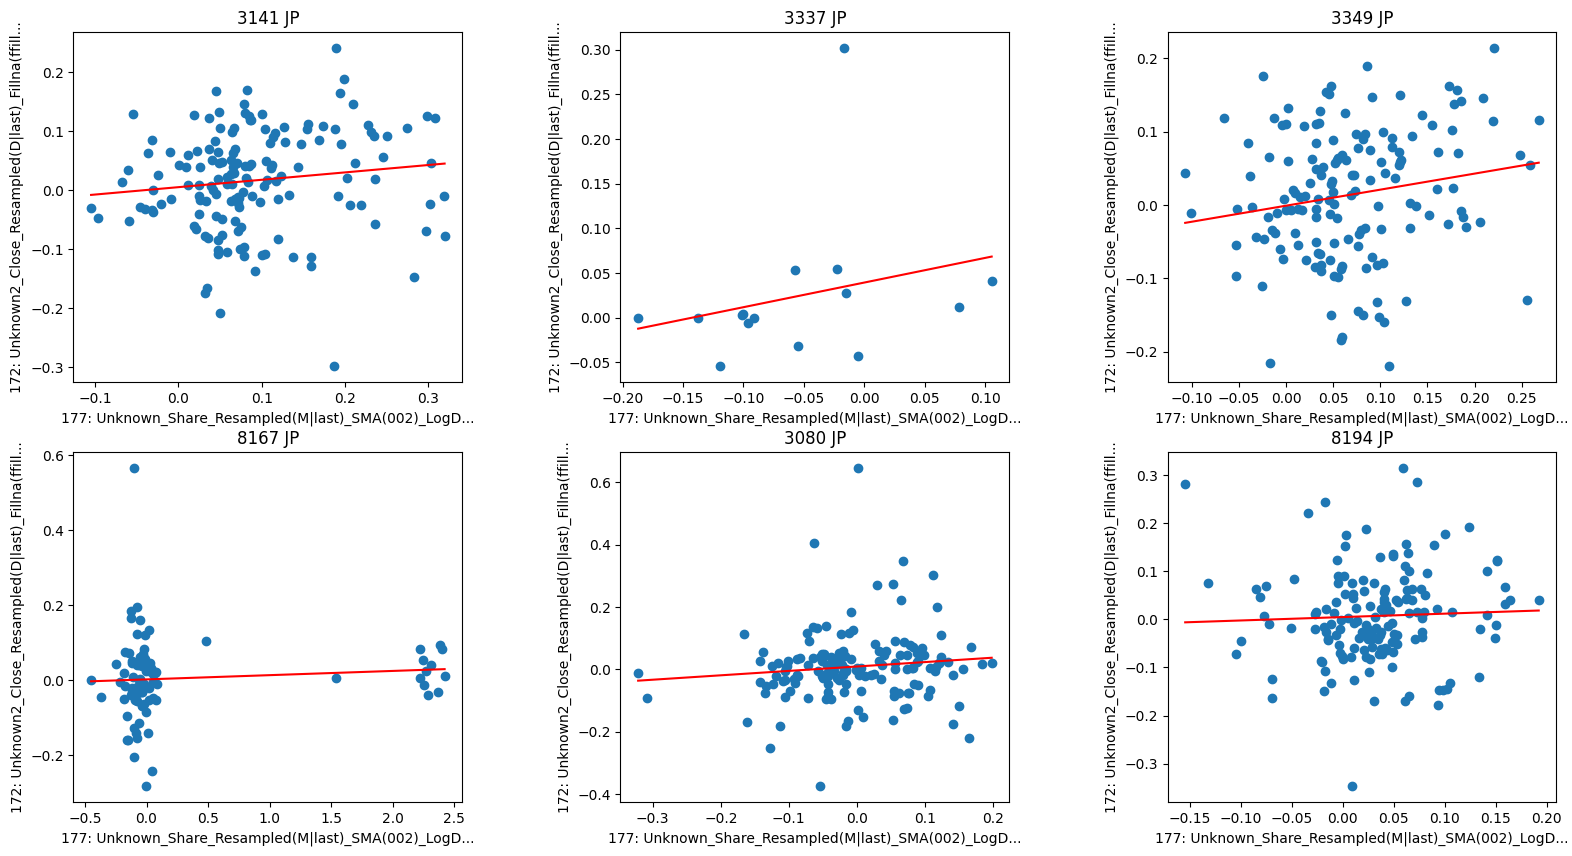

In [27]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=close_return,
    x=feature,
    targets=top6tickers,
    col_num=3,
    vname_len_limit=45
)

## バックテスト
> 株価変化率ともっとも相関の良い特徴量をシグナルにして、ポートフォリオ分析を実施します.

In [28]:
# define the parameters for factor choice.
nq = 3
exe_cost = 0.0005

In [29]:
dfqret, stats, dfsigqt = ade.q_backtest(
    feature,
    close_return,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,0.688937,0.054347,0.133476,0.407164,0.588235,3.170782,-0.347596,0.156350
#2,1.046706,0.082569,0.135153,0.610930,0.633987,4.528319,-0.273139,0.302298
#3,1.499124,0.118258,0.141990,0.832862,0.640523,3.300810,-0.303099,0.390163
#3-#1,0.810187,0.063911,0.066114,0.966682,0.647059,6.471592,-0.087036,0.734308
#3-#1(cost),0.769168,0.060676,0.066113,0.917762,0.620915,6.471592,-0.088715,0.683940
